# Special case: gaseous species
In this short special case tutorial we will discuss how to handle gaseous compounds both in the in- and outlet of the reactor, the most common molecules of this type is CO2 and O2. These species are  not accounted for in the feed medium and since they evaporate the liquid concentration does not account for all the produced mass. Thus, we setup the full mass balance for the species.

$$
\frac{dM_{species}}{dt}=In_{gas}+In_{liquid}-Out_{gas}+Metabolism-Sampled
$$
where $M_{species}$ is the total amount of species in the reactor in both gas and aqueous phase. The term metabolism is the net value and covers both production (positive) and consumption (negative).

Data about the gaseous entering and leaving a bioreactor is usually expressed in terms of total amount over time. However, the pseudo batch transformation can only work with concentrations and therefore we treat these species as entirely solubilized and assign them a “hypothetical concentration”, which we then perform the pseudobatch correction on.

The pseudobatch package presents a function to preprocess the in- and outlet gas data into a hypothetical concentration, which can be transformed with the pseudobatch transformation. In this tutorial we will go through three examples

1. Highly insoluble produced compound, exemplified by $CO_2$
2. Highly insoluble consumed compound, exemplified by $O_2$
3. Partially insoluble compound, exemplified by a generic product

In this tutorial we will work with a simulated dataset. We have made some simplifying assumptions for demonstration purposes:
- CO2 is insoluble in media. Therefore, all CO2 produced is measured in the off-gas analysis (the out stream). There is no need to account for CO2 in the media, and therefore no need to account for CO2 lost due to sampling. 
- No CO2 is fed into the reactor.
- O2 can be consumed directly from the gas-phase. This circumvents the need to explicitly model the gas-transfer between from air to liquid. Due to this model formulation O2 is also not affected by the sampling.
- Evaporation of the volatile product follows first order kinetics.

The preprocessing function treats the gaseous and liquid mass differently, thus before applying the preprocessing function 
We can calculate this by isolating the metabolism variable in the mass balance above.
$$
Metabolism = Out + \sout{Sampled} + \sout{Dissolved} - In
$$

Now, we are ready to setup the programming environment and load the data.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas, preprocess_gaseous_species
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
# fedbatch_df = load_standard_fedbatch()
fedbatch_df = _prepare_simulated_dataset("../../../article/data/volatile_product.csv")

## Transforming a highly insoluble produced compound, $CO_2$

The test dataset contain simulated the accumulated $CO_2$ production measurements in mass units in the column `m_CO2_gas`. Further, we se that the concentration of CO2 in the liquid phase is zero at all times. This is because in the simulation we assume that CO2 evaporated immediately after production as was stated earlier.

array([[<Axes: xlabel='timestamp'>],
       [<Axes: xlabel='timestamp'>]], dtype=object)

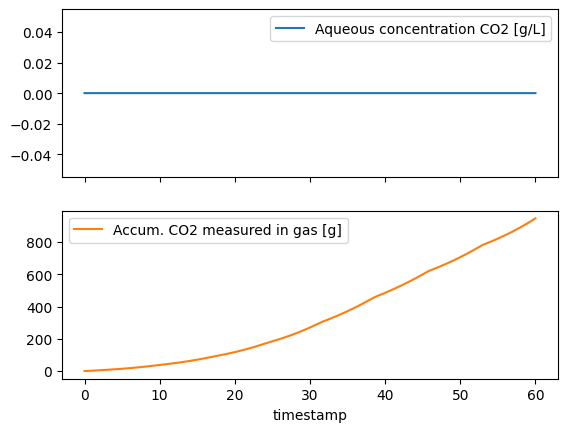

In [3]:
fedbatch_df.plot(x='timestamp', y=['c_CO2', 'm_CO2_gas'], subplots=True, layout=(2,1), label=['Aqueous concentration CO2 [g/L]', 'Accum. CO2 measured in gas [g]'])

Notice, how the production rate of CO2 (g/h) decrease the bioreactor is sampled. This is because the total amount of biomass decrease after sampling, thus there is less biomass to produce CO2. We will now use the `preprocess_gaseous_species()` to prepare the data for pseudo batch transformation. The `accumulated_gas_amount` argument should get the difference between the gas inlet and the outlet. Because there is no CO2 in the inlet gas and the liquid concentration of CO2 is zero, then we can calculate the hypothetical CO2 concentration as follows

In [4]:
fedbatch_df['hypothetical_c_CO2'] = preprocess_gaseous_species(
    accumulated_gas_amount=fedbatch_df['m_CO2_gas'].values,
    liquid_concentration=np.zeros_like(fedbatch_df['m_CO2_gas'].values),
    reactor_volume=fedbatch_df['v_Volume'].values,
    sample_volume=fedbatch_df['sample_volume'].values
)

Now, we can transform the hypothetical CO2 concentration and the biomass concentration measurements.

In [5]:
fedbatch_df[['pseudo_Biomass', 'pseudo_CO2']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "hypothetical_c_CO2"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,0],
    sample_volume_colname='sample_volume'
)


If we estimate the CO2 yield using the pseudobatch transformed data we obtain the exact simulated value.

In [6]:
Yxco2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_CO2'], 1)
print(f"Yxco2_hat = {Yxco2_hat}")
print(f"true Yxco2 = {fedbatch_df['Yxco2'].iloc[-1]}")

Yxco2_hat = 0.045193332445214125
true Yxco2 = 0.0451933324452141


## Transforming highly insoluble consumed compound, Oxygen
The O2 data can be transformed in a very similar manner to CO2, but here we need to calculated the total O2 metabolized over time. We can calculate this by isolating the metabolism variable in the mass balance above.
$$
Metabolism = Out + \sout{Sampled} + \sout{Dissolved} - In
$$
The simulated data holds the total O2 added over time, `m_O2_in` and the total O2 exiting the reactor over time, `m_O2_gas`.

<Axes: >

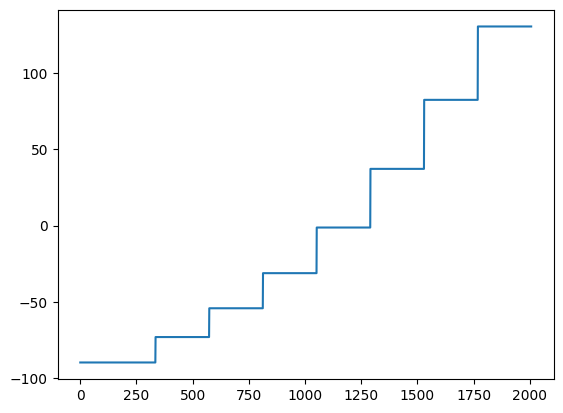

In [7]:
## Check mass balance

o2_balance = fedbatch_df['m_O2_in'] - fedbatch_df['m_O2'] - (fedbatch_df['Yxo2'] * fedbatch_df['m_Biomass']) - fedbatch_df['m_O2_gas']
o2_balance.plot()

array([<Axes: xlabel='timestamp', ylabel='Accumulated $O_2$ mass [g]'>,
       <Axes: xlabel='timestamp', ylabel='Accumulated $O_2$ mass [g]'>,
       <Axes: xlabel='timestamp', ylabel='Accumulated $O_2$ mass [g]'>],
      dtype=object)

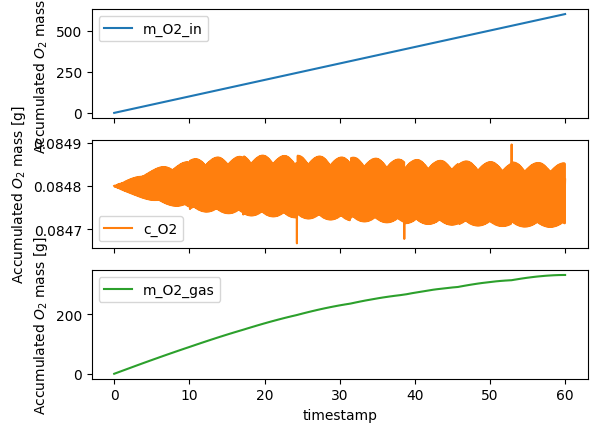

In [8]:
fedbatch_df.plot(x='timestamp', y=['m_O2_in','c_O2','m_O2_gas'], subplots=True, ylabel=r'Accumulated $O_2$ mass [g]')

Before calculating the hypothetical concentration, we need to calculate the consumed oxygen. The general formula for this is 


In [20]:
fedbatch_df['m_O2_after_sample'] = fedbatch_df['m_O2'] - fedbatch_df['c_O2'] * fedbatch_df['sample_volume']
fedbatch_df['m_O2_consumed'] =  + fedbatch_df['m_O2_in'] - fedbatch_df['m_O2_gas'] - fedbatch_df['m_O2_after_sample'] - fedbatch_df['c_O2'] * fedbatch_df['sample_volume'].cumsum()
# fedbatch_df['m_O2_consumed'] = fedbatch_df['m_O2_gas'] - fedbatch_df['m_O2_in']
fedbatch_df['hypothetical_c_O2'] = preprocess_gaseous_species(
    accumulated_gas_amount=fedbatch_df['m_O2_consumed'].to_numpy(),
    liquid_concentration=fedbatch_df['c_O2'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy(),
)

fedbatch_df['pseudo_O2'] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=['hypothetical_c_O2'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0],
    sample_volume_colname='sample_volume',
)

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

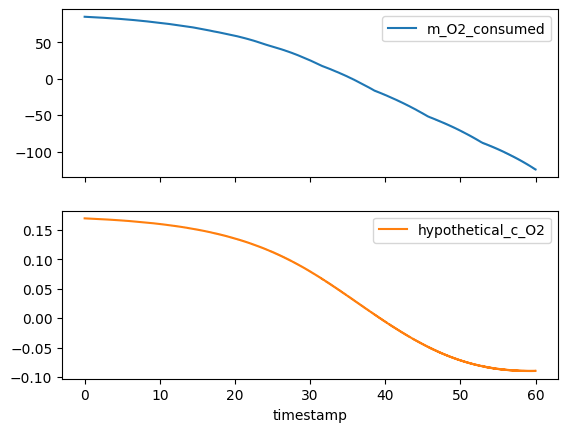

In [21]:
fedbatch_df.plot(x='timestamp', y=['m_O2_consumed', 'hypothetical_c_O2'], subplots=True)

In [22]:
Yxo2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_O2'], 1)
print(f"Yxo2_hat = {Yxo2_hat}")
print(f"true Yxo2 = {fedbatch_df['Yxo2'].iloc[-1]}")

Yxo2_hat = -0.006914204825173315
true Yxo2 = 0.01


<Axes: xlabel='pseudo_Biomass'>

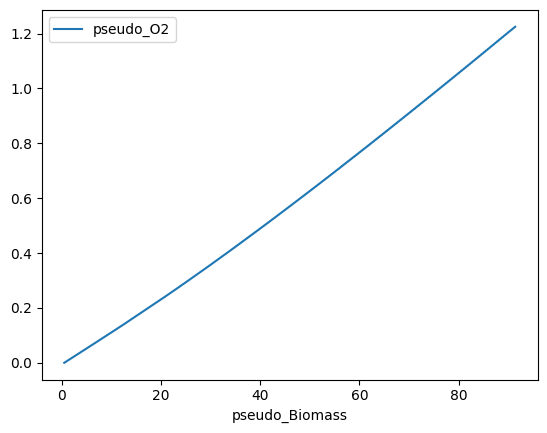

In [12]:
fedbatch_df.plot(x='pseudo_Biomass', y='pseudo_O2')

## Volatile product


<Axes: xlabel='timestamp'>

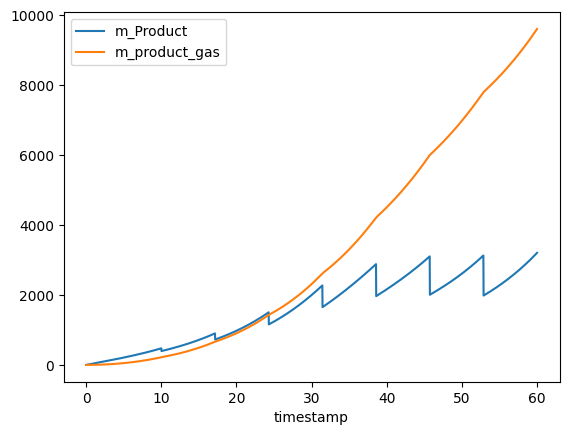

In [13]:
fedbatch_df.plot(
    x='timestamp',
    y=['m_Product', 'm_product_gas']
)

<Axes: >

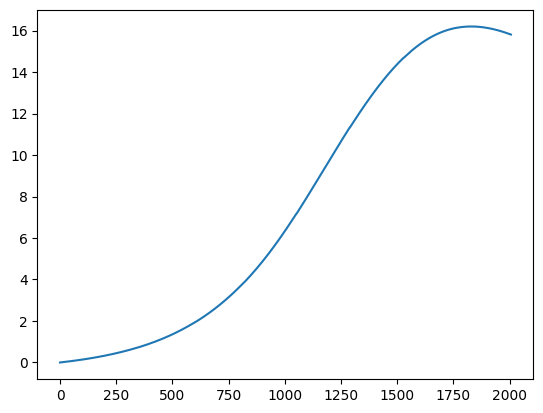

In [14]:
fedbatch_df['hypothetical_c_Product'] = preprocess_gaseous_species(
    accumulated_gas_amount=fedbatch_df['m_product_gas'].values,
    liquid_concentration=fedbatch_df['c_Product'].values,
    reactor_volume=fedbatch_df['v_Volume'].values,
    sample_volume=fedbatch_df['sample_volume'].values
)
fedbatch_df.hypothetical_c_Product.plot()

In [15]:
fedbatch_df['pseudo_Product'] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames='hypothetical_c_Product',
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0],
    sample_volume_colname='sample_volume'
)

In [16]:
Yxp_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_Product'], 1)
print(f"Yxp_hat = {Yxp_hat}")
print(f"true Yxp = {fedbatch_df['Yxp'].iloc[-1]}")

Yxp_hat = 0.8215102466751059
true Yxp = 0.8215102466751038
